In [1]:
import xarray as xr
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle


from skimage.measure import label, regionprops, perimeter

import math
import sys
#sys.path.append('../../util')
#from curvature import *


In [2]:
def calc_BLW(fld, dx = 3.3e3, perc=88):
    ### Input:Column Water Vapour (x, y)
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    ### Parameters: dx grid spacing of input field, perc 
    
    binary = np.where(fld > np.percentile(fld, perc, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)
    A_tot = np.sum(binary)*(dx**2) #Area equals to the number of grid points times the gridspacing
    
    BLW = 2*np.sqrt(np.pi*A_tot)/(dx*perimeter(binary))
    
    return BLW

In [3]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [15]:
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_TQV = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

for TTT in np.arange(296,305):
    i = TTT-296 #index
    try:
        d2D = pickle.load( open('pickles/output_'+str(TTT)+'.pkl', "rb" ) )
    except:
        path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
        d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )
   
    tqv = d2D.TQV.isel(time=slice(24*85, None))
    
    #Compute mean histogram
    h = np.zeros((tqv.time.size, 100))
    e = np.zeros((tqv.time.size, 101))
    for t in range(tqv.time.size):
        h[t,:], e[t,:] = np.histogram(tqv.isel(time=t).values, density = True, bins = 100)
    
    hist[i,:] = np.mean(h,axis=0)
    edges[i,:] = np.mean(e,axis=0)

    #Compute BLW
    for t in range(tqv.time.size):
        BLW[i] = np.mean(calc_BLW(tqv.isel(time=t).values))
    
    #Compute other indices
    mean_TQV[i] = tqv.mean()
    perc[i]=np.percentile(tqv, 88)
    median[i]=np.percentile(tqv, 50)

    
#Save data
with open('pickles/dT_hist.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/dT_edges.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/dT_BLW.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/dT_mean_TQV.pkl', 'wb') as pickle_file:
    pickle.dump(mean_TQV, pickle_file)
        
with open('pickles/dT_p88.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/dT_median.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

In [240]:
hist = pickle.load( open( 'pickles/dT_hist.pkl', "rb" ) )
edges = pickle.load( open( 'pickles/dT_edges.pkl', "rb" ) )
BLW = pickle.load( open( 'pickles/dT_BLW.pkl', "rb" ) )
mean_TQV = pickle.load( open( 'pickles/dT_mean_TQV.pkl', "rb" ) )                            
perc = pickle.load( open( 'pickles/dT_p88.pkl', "rb" ) )
median = pickle.load( open( 'pickles/dT_median.pkl', "rb" ) )

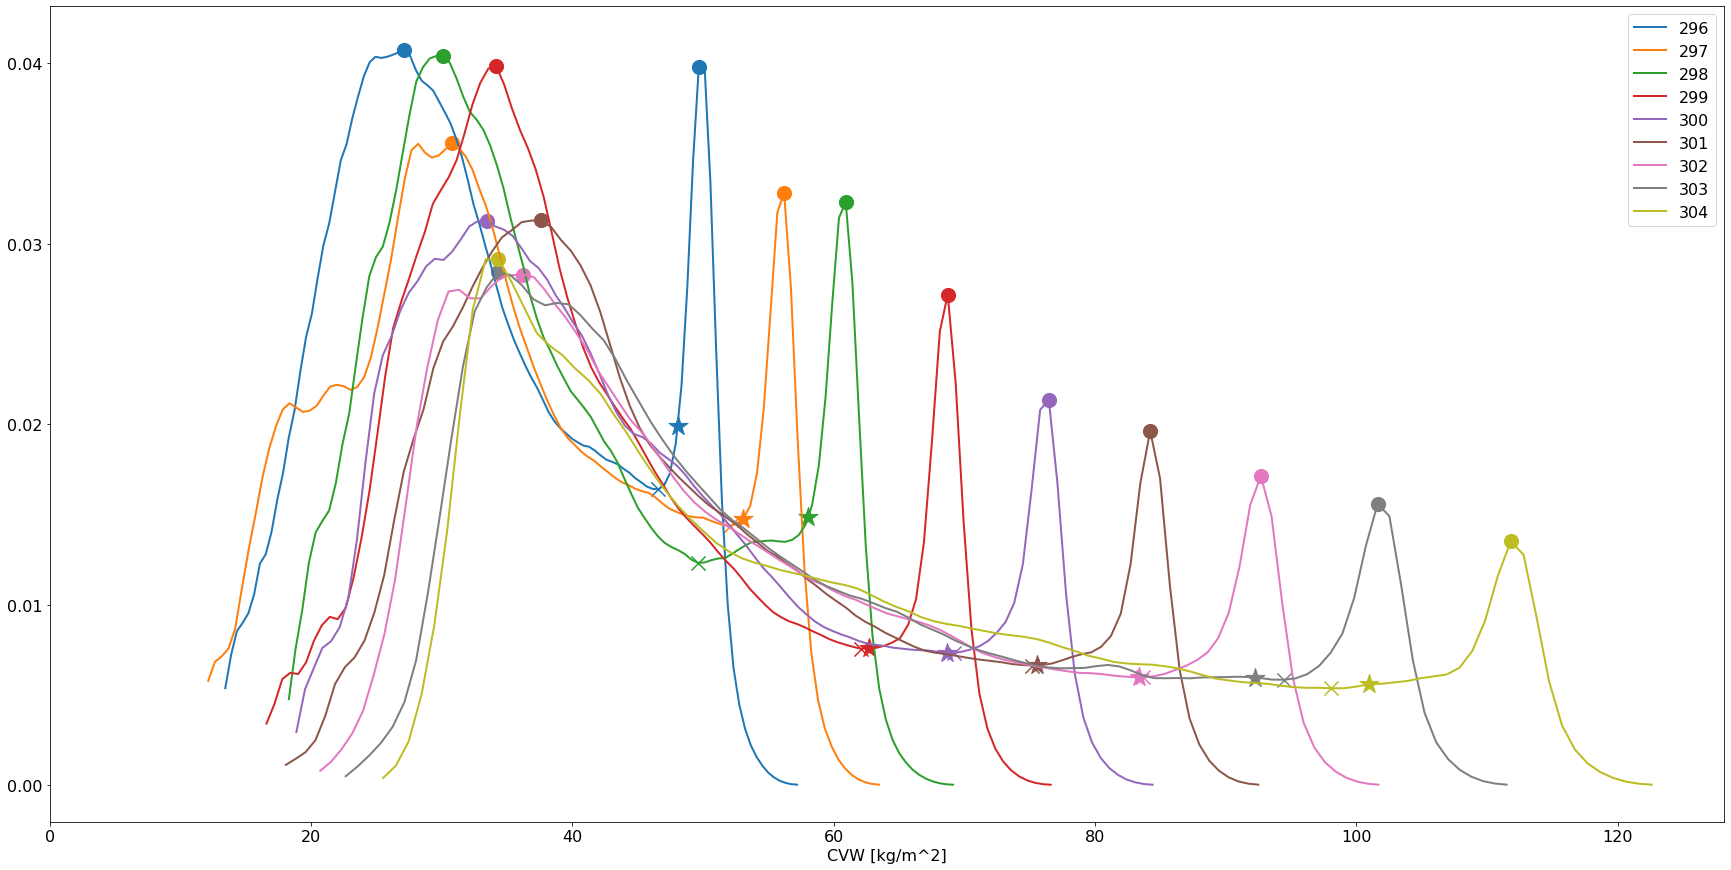

In [258]:

lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 16})
#plt.xlim(left=0)

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(left=0)
plt.xlabel('CVW [kg/m^2]')
plt.legend()

plt.savefig('dSST_CWV_PDF.pdf')

Text(0.5, 0, 'percentile')

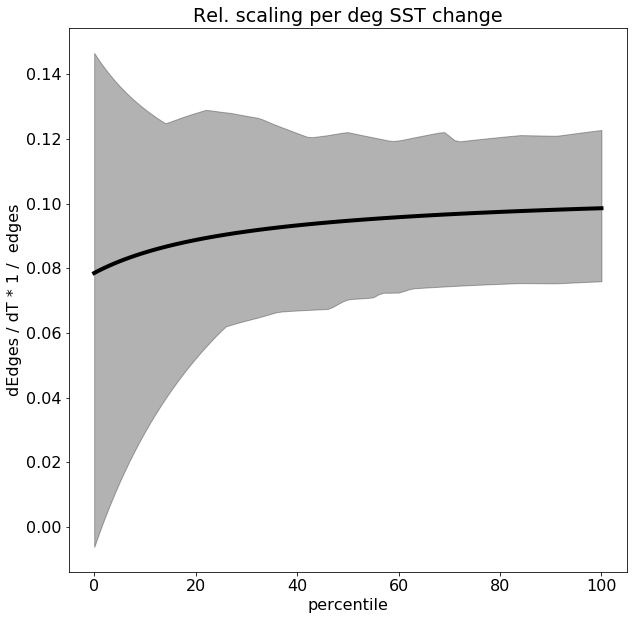

In [78]:
fig=plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})

redges=np.zeros((100, 101))
for i in range(100):
    ind = np.random.choice(range(0, len(edges)), 2, replace=False)
    redges[i,:]=np.diff(edges[ind,:], axis=0) /  edges[ind[0],:] / np.diff(ind)

plt.plot( np.mean(redges, axis=0), color='k', linewidth=4)
plt.fill_between(np.arange(101), np.percentile(redges, 10, axis=0), np.percentile(redges, 90, axis=0), color='k', alpha=0.3)

plt.title('Rel. scaling per deg SST change')
plt.ylabel('dEdges / dT * 1 /  edges')
plt.xlabel('percentile')


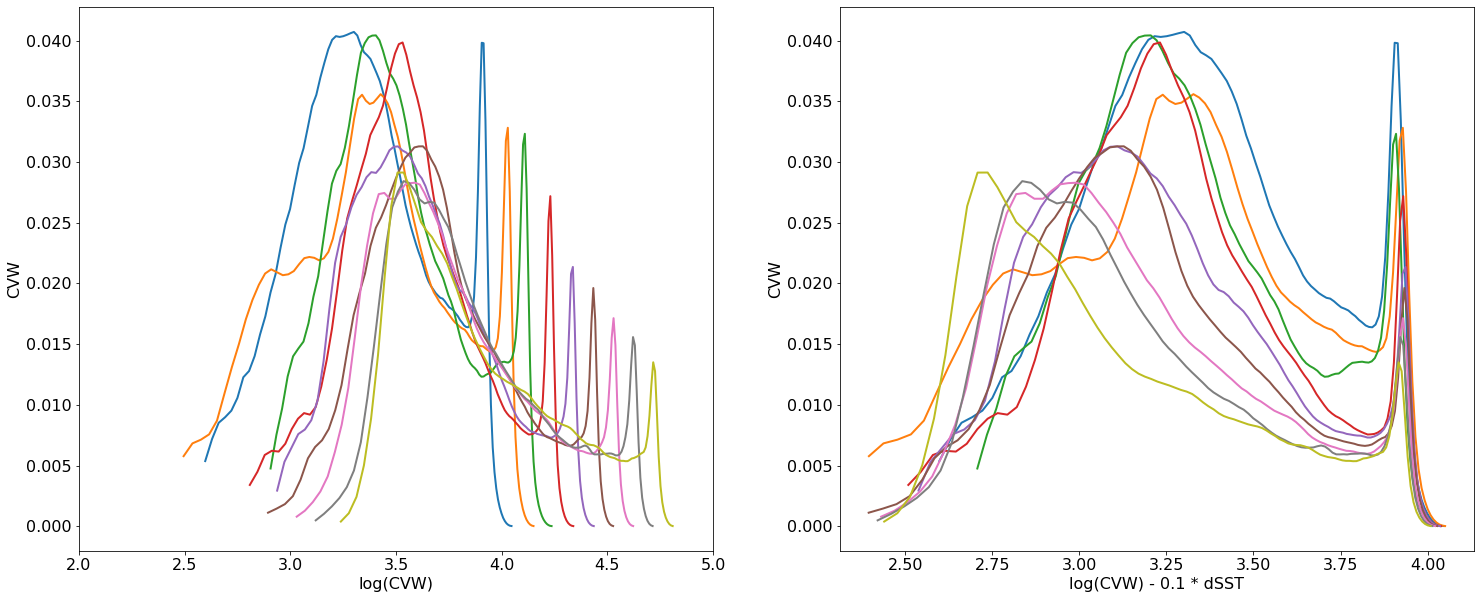

In [79]:


lmax = np.zeros((9,2))
lmin = np.zeros(9)


fig=plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 16})


plt.subplot(1,2,1)
for i in range(9):
    plot = plt.plot(np.log(edgTObin(edges[i,:])) , hist[i],  linewidth=2, label=str(296+i))
    plt.xlim(2,5)
    plt.xlabel('log(CVW)')
    plt.ylabel('CVW')
        
plt.subplot(1,2,2)
for i in range(9):
    plot = plt.plot( np.log(edgTObin(edges[i,:])) - 0.1 * i ,  hist[i],  linewidth=2, label=str(296+i))
    #plt.xlim(2,5)
    plt.xlabel('log(CVW) - 0.1 * dSST')
    plt.ylabel('CVW')

In [157]:
np.random.choice(np.arange(len(x)), len(x)-1, replace=True)
x[ind]
lmax[ind,0] 

array([37.62035813, 30.79505213, 30.10682421, 33.43581538, 34.33795328,
       27.13350206, 36.24677253, 34.16811446, 37.62035813])

88th percentile 0.09147527131081082
Anti Mode 0.10055194509166726
Dry Mode 0.02829011106899778
Moist Mode 0.09846448741198706
Mean 0.07832752310659617


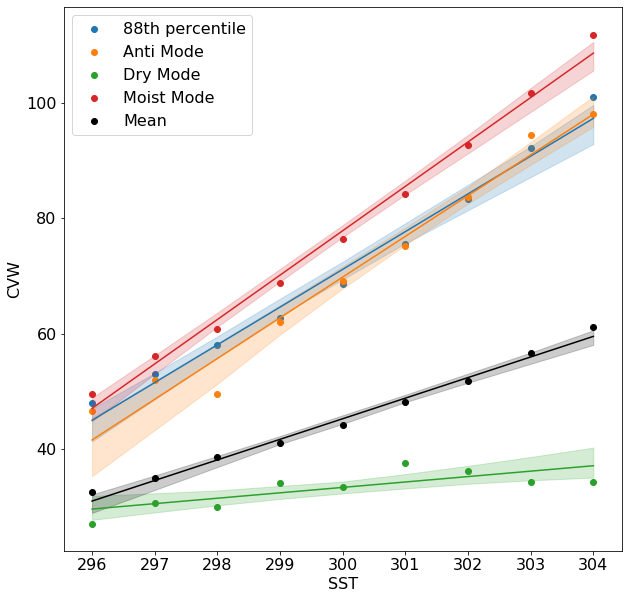

In [257]:
fig=plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
x = np.arange(296,305)
y = np.zeros((100,9))
m = np.zeros((100))

plt.scatter(x, perc, label='88th percentile')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], perc[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('88th percentile',np.mean(m)/np.mean(perc[:]))


plt.scatter(x, lmin, label='Anti Mode')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], lmin[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('Anti Mode',np.mean(m)/np.mean(lmin[:]))


plt.scatter(x, lmax[:,0], label='Dry Mode')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], lmax[ind,0], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())

print('Dry Mode',np.mean(m)/np.mean(lmax[:,0]))




plt.scatter(x, lmax[:,1], label='Moist Mode')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], lmax[ind,1], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0))
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('Moist Mode',np.mean(m)/np.mean(lmax[:,1]))




plt.scatter(x, mean_TQV, label='Mean', color='k')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], mean_TQV[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0), color='k')
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())
print('Mean',np.mean(m)/np.mean(mean_TQV[:]))


plt.ylabel('CVW')
plt.xlabel('SST')

plt.legend()


plt.savefig('dSST_mode_sclaing.pdf')

# Scaling of BLW

In [13]:
def calc_BLW_rel(fld, dx = 3.3e3, th=40):
    ### Input:Column Water Vapour (x, y)
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    ### Parameters: dx grid spacing of input field, perc 
    
    binary = np.where(fld > th[np.newaxis, np.newaxis], 1, 0)
    A_tot = np.sum(binary)*(dx**2) #Area equals to the number of grid points times the gridspacing
    
    BLW = 2*np.sqrt(np.pi*A_tot)/(dx*perimeter(binary))
    
    return BLW

In [ ]:
BLW = np.zeros(9)
BLW_max = np.zeros(9)
BLW_min = np.zeros(9)

for TTT in np.arange(296,305):
    i = TTT-296 #index
    try:
        d2D = pickle.load( open('pickles/output_'+str(TTT)+'.pkl', "rb" ) )
    except:
        path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
        d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )
   
    tqv = d2D.TQV.isel(time=slice(24*60, None))


    #Compute BLW
    for t in range(tqv.time.size):
        BLW[i] = np.mean(calc_BLW(tqv.isel(time=t).values))
        BLW_max[i] = np.mean(calc_BLW_rel(tqv.isel(time=t).values, th=lmax[i,1]))
        BLW_min[i] = np.mean(calc_BLW_rel(tqv.isel(time=t).values, th=lmin[i]))

with open('pickles/dT_BLW.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)ry
    
with open('pickles/dT_BLW_max.pkl', 'wb') as pickle_file:
    pickle.dump(BLW_max, pickle_file)

with open('pickles/dT_BLW_min.pkl', 'wb') as pickle_file:
    pickle.dump(BLW_min, pickle_file)


In [245]:
BLW = pickle.load( open( 'pickles/dT_BLW.pkl', "rb" ) )
BLW_max = pickle.load( open( 'pickles/dT_BLW_max.pkl', "rb" ) )
BLW_min = pickle.load( open( 'pickles/dT_BLW_min.pkl', "rb" ) )



BLW 0.020737122310548962
BLW_min 0.012177367757891936


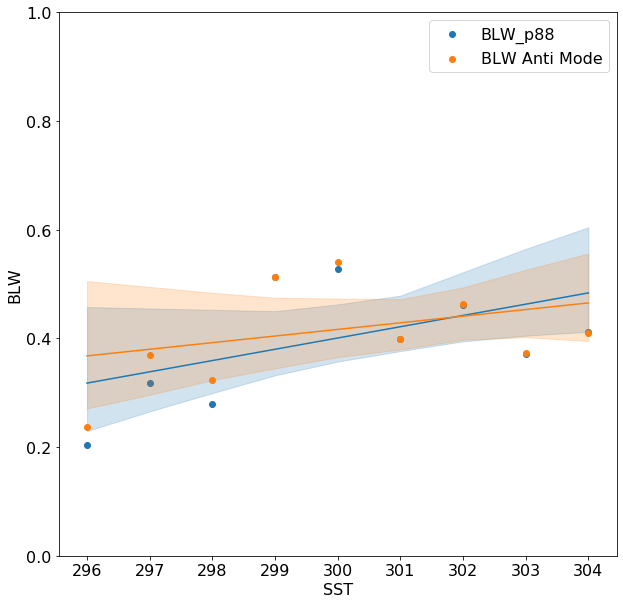

In [254]:
fig=plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})


x = np.arange(296,305)
y = np.zeros((100, 9))
m = np.zeros((100))

plt.scatter(x, BLW, label='BLW_p88', color='C0')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], BLW[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0), color='C0')
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())

print('BLW',np.mean(m))



plt.scatter(x, BLW_min, label='BLW Anti Mode', color='C1')
for i in range(100):
    ind = np.random.choice(np.arange(len(x)), len(x), replace=True)
    m[i], b = np.polyfit(x[ind], BLW_min[ind], 1)
    y[i,:]=m[i]*x + b

plot = plt.plot(x, np.mean(y, axis=0), color='C1')
plt.fill_between(x, np.percentile(y,5, axis=0), np.percentile(y,95, axis=0), alpha=0.2, color=plot[0].get_color())

print('BLW_min',np.mean(m))

plt.xlabel('SST')
plt.ylabel('BLW')
plt.ylim(0,1)
plt.legend()

plt.savefig('dSST_BLW_sclaing.pdf')

### CRH

In [ ]:
ulvl=47 #Upper level for RH integration. 47 is about 10km
hist = np.zeros((9, 100))
edges = np.zeros((9,101))
mean_CRH = np.zeros(9)
mean_P = np.zeros(9)
BLW = np.zeros(9)
perc = np.zeros(9)
median=np.zeros(9)

for TTT in np.arange(296,305):
    i = TTT-296 #index
    
    #Open constants file
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
    const = xr.open_mfdataset(path+'output_3D/lfff00000000c.nc', combine='by_coords', )
    
    try:
        d3D = pickle.load( open('pickles/output_3D_'+str(TTT)+'.pkl', "rb" ) )
    except:
        path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
        d3D = xr.open_mfdataset(path+'output_3D/lfff????0000.nc', combine='by_coords', )
   
        with open('pickles/output_3D_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(d3D, pickle_file)
        
    dz = const.HHL.differentiate("level1",)[0,:,:,:].rename({'level1': 'level'}) * -1 #Level thickness
    crh  = d3D.RELHUM.isel(time=slice(4*85, None), level=slice(ulvl, None)).weighted(dz[ulvl:-1,:,:]).mean(dim='level')
    
    #Compute mean histogram
    h = np.zeros((crh.time.size, 100))
    e = np.zeros((crh.time.size, 101))
    for t in range(crh.time.size):
        h[t,:], e[t,:] = np.histogram(crh.isel(time=t).values, density = True, bins = 100)
    
    hist[i,:] = np.mean(h,axis=0)
    edges[i,:] = np.mean(e,axis=0)

    #Compute BLW
    for t in range(crh.time.size):
        BLW[i] = np.mean(calc_BLW(crh.isel(time=t).values))
    
    #Compute other indices
    mean_CRH[i] = crh.mean()
    perc[i]=np.percentile(crh, 88)
    median[i]=np.percentile(crh, 50)

    
#Save data
with open('pickles/CRH_dT_hist.pkl', 'wb') as pickle_file:
    pickle.dump(hist, pickle_file)
        
with open('pickles/CRH_dT_edges.pkl', 'wb') as pickle_file:
    pickle.dump(edges, pickle_file)
        
with open('pickles/CRH_dT_BLW.pkl', 'wb') as pickle_file:
    pickle.dump(BLW, pickle_file)
        
with open('pickles/CRH_dT_mean_CRH.pkl', 'wb') as pickle_file:
    pickle.dump(mean_CRH, pickle_file)
        
with open('pickles/CRH_dT_p88.pkl', 'wb') as pickle_file:
    pickle.dump(perc, pickle_file)
    
with open('pickles/CRH_dT_median.pkl', 'wb') as pickle_file:
    pickle.dump(median, pickle_file)

/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/users/davidle/v

In [ ]:
hist = pickle.load( open( 'pickles/CRH_dT_hist.pkl', "rb" ) )
edges = pickle.load( open( 'pickles/CRH_dT_edges.pkl', "rb" ) )
BLW = pickle.load( open( 'pickles/CRH_dT_BLW.pkl', "rb" ) )
mean_TQV = pickle.load( open( 'pickles/CRH_dT_mean_TQV.pkl', "rb" ) )                            
perc = pickle.load( open( 'pickles/CRH_dT_p88.pkl', "rb" ) )
median = pickle.load( open( 'pickles/CRH_dT_median.pkl', "rb" ) )

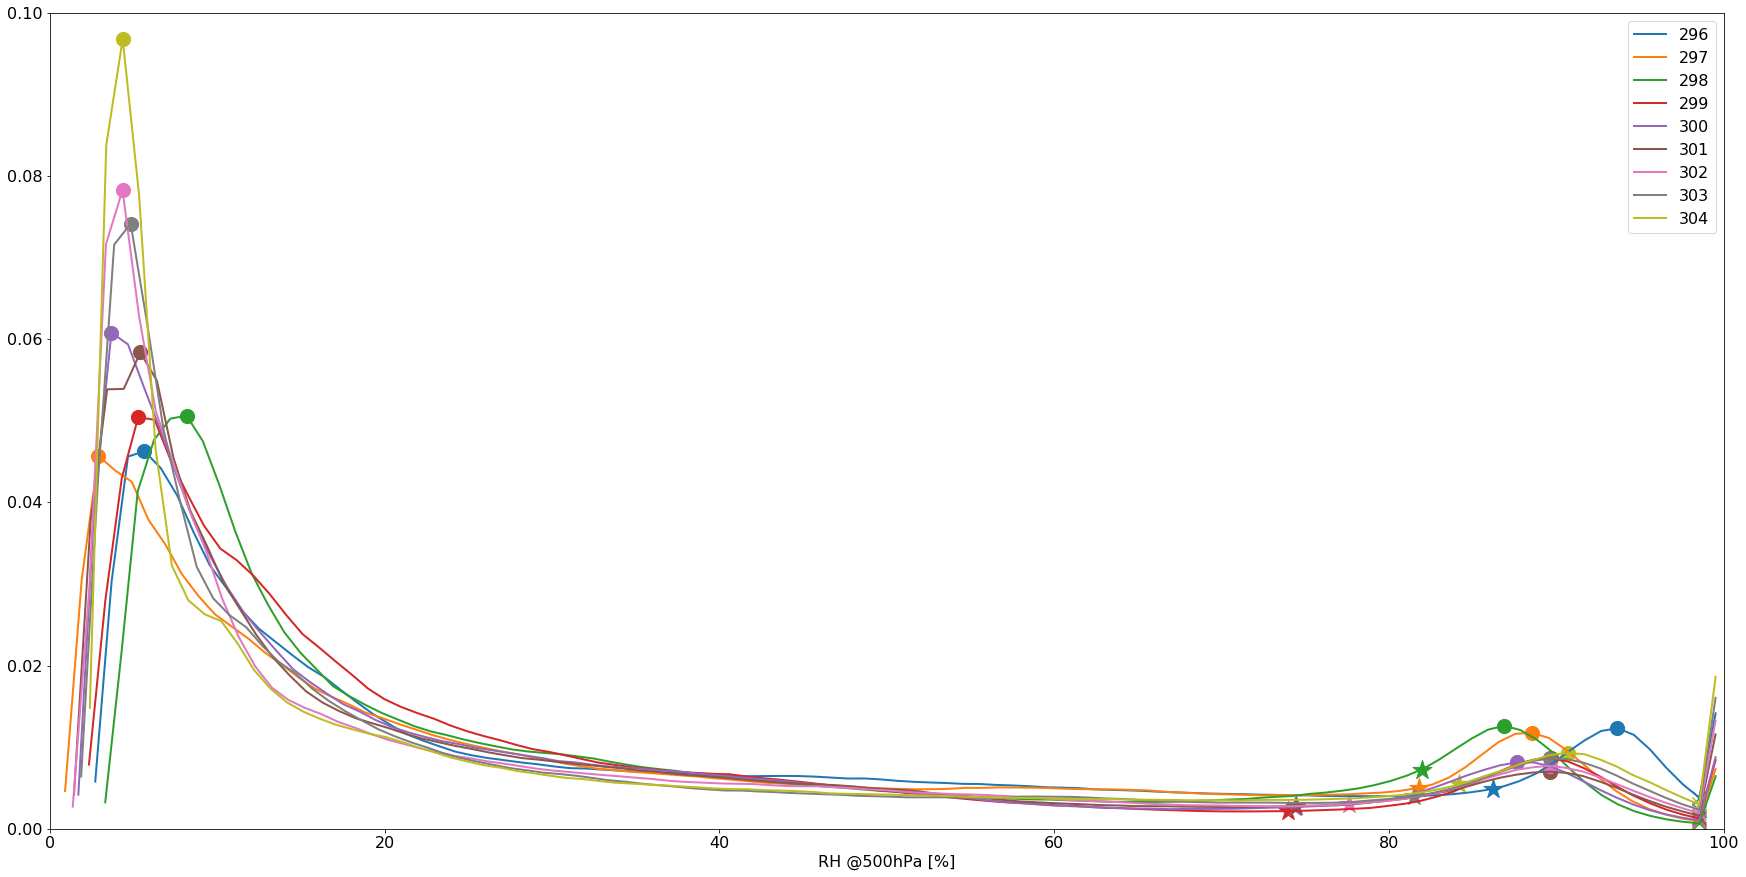

In [36]:

lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 16})

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(0,100)
plt.ylim(0,0.1)
plt.xlabel('CRH [%]')
plt.legend()

#plt.savefig('dSST_CWV_PDF.pdf')

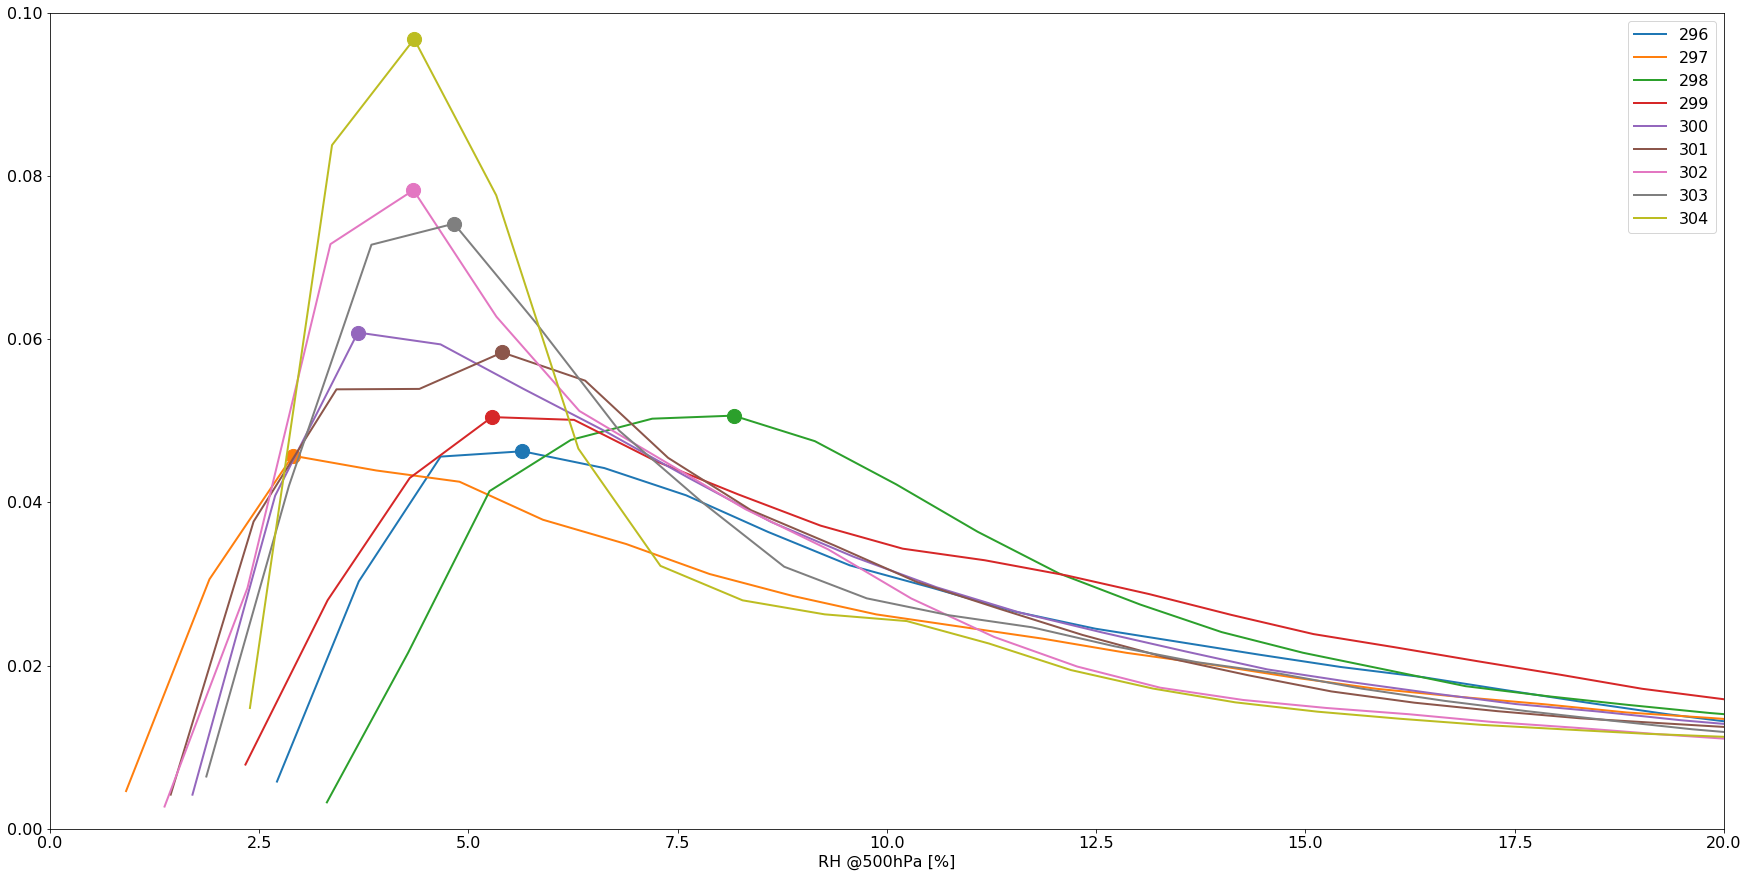

In [37]:

lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 16})

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(0,20)
plt.ylim(0,0.1)
plt.xlabel('RH @500hPa [%]')
plt.legend()

#plt.savefig('dSST_CWV_PDF.pdf')

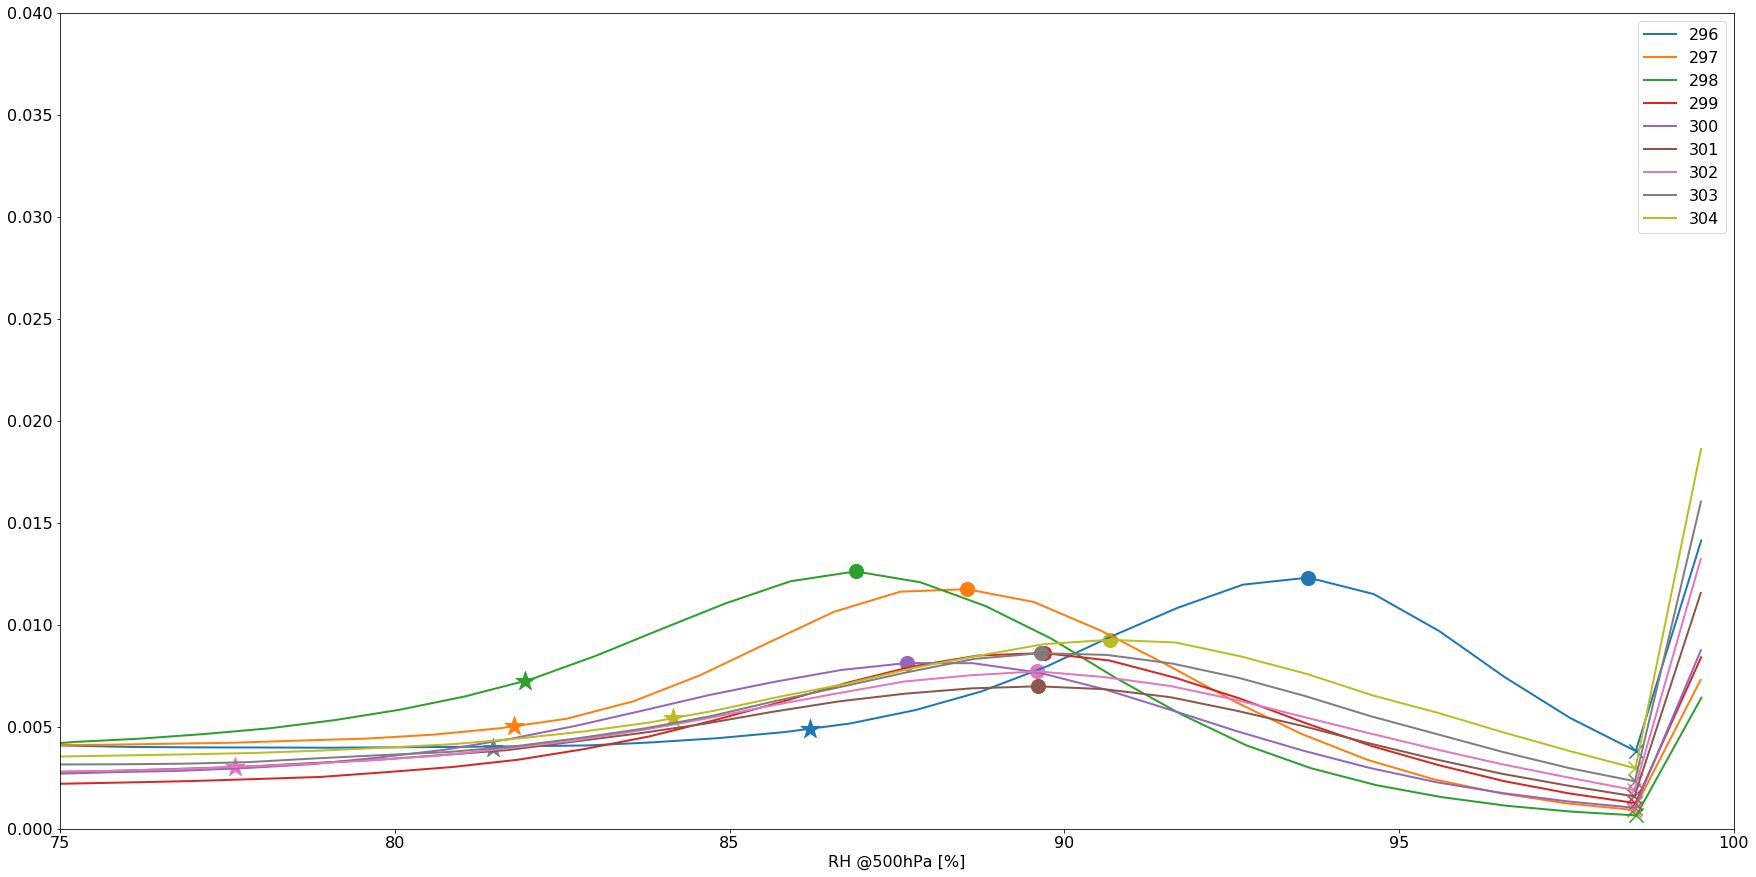

In [40]:

lmax = np.zeros((9,2))
lmin = np.zeros(9)

fig=plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 16})

for i in range(9):
    lmax[i,0] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][0]
    lmax[i,1] = edgTObin(edges[i,:])[sp.signal.argrelmax(hist[i,:], order=5)][-1]
    lmin[i] = edgTObin(edges[i,:])[sp.signal.argrelmin(hist[i,:], order=5)][-1]
    
    plot = plt.plot(edgTObin(edges[i]), hist[i],  linewidth=2, label=str(296+i))
    color = plot[0].get_color()
    
    plt.scatter(perc[i],y=np.interp(x=perc[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='*') #Add marker of percentile
    #plt.scatter(median[i],y=np.interp(x=median[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=400, color=color, marker='+') #Add marker of percentile
    plt.scatter(lmax[i,0],y=np.interp(x=lmax[i,0],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 1st maximum
    plt.scatter(lmax[i,1],y=np.interp(x=lmax[i,1],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color) #Add marker of 2nd maximum
    plt.scatter(lmin[i],y=np.interp(x=lmin[i],xp=edgTObin(edges[i,:]),fp=hist[i,:]),s=200, color=color,  marker='x') #Add marker of minimum


plt.xlim(75,100)
plt.ylim(0,0.04)
plt.xlabel('RH @500hPa [%]')
plt.legend()

#plt.savefig('dSST_CWV_PDF.pdf')